# Logistic Regression with Scikit-Learn

## Libraries

The libraries used to image load and processing are,

* `imageio`
* `OpenCV (cv2)`
* `Numpy`
* `scikit-learn`
* `matplotlib` to plot results in order to depurate things

Which will be used in the helper functions shown on a section below.


# Helper functions

In order to load the images from the annotations file `gt.txt` I needed a set of helper functions.
The doc-strings on the functions are self-explanatory, but in summary,

* `annotation_parser` : extracts information from an annotation word  
* `get_annotated_ROI` : gets the ROI for a given annotation  
* `create_data_set_from_annotations` : generates a shuffled data set reading from an annotations file  
* `split_data` : splits the data into two batches, for training and testing.  

In [2]:
# Set parameters
learning_rate = 0.0035
training_iteration = 30
batch_size = 121
display_step = 10
test_size = 0.2

input_image_shape = (28,28)

In [3]:
def annotation_parser(annotation, sep=";"):
    """
    anotation_parser extracts information of the ROI for a single annotation
    
    Input
    -----
    - annotation(string): The annotation for a single image
    - sep(string): The separator for the annotations. (default ";")
    
    Returns
    -------
    - filename(string): The name of the file corresponding to the annotation
    - left_column(int): Coordinates for left column of the ROI
    - top_row(int): Coordinates of the top row of the ROI
    - right_column(int): Coordinates of the left column of the ROI
    - bottom_row(int): Coordinates of the bottom row of the ROI
    - category(int): The numerical category the image in the ROI belongs to
    
    """
    filename, left_column, top_row, right_column, bottom_row, category = annotation.split(sep)
    return filename, int(left_column), int(top_row), int(right_column), int(bottom_row), int(category)    

To test how the annotation_parser works, I picked a line of the gt.txt and used it to check how the function above worked 

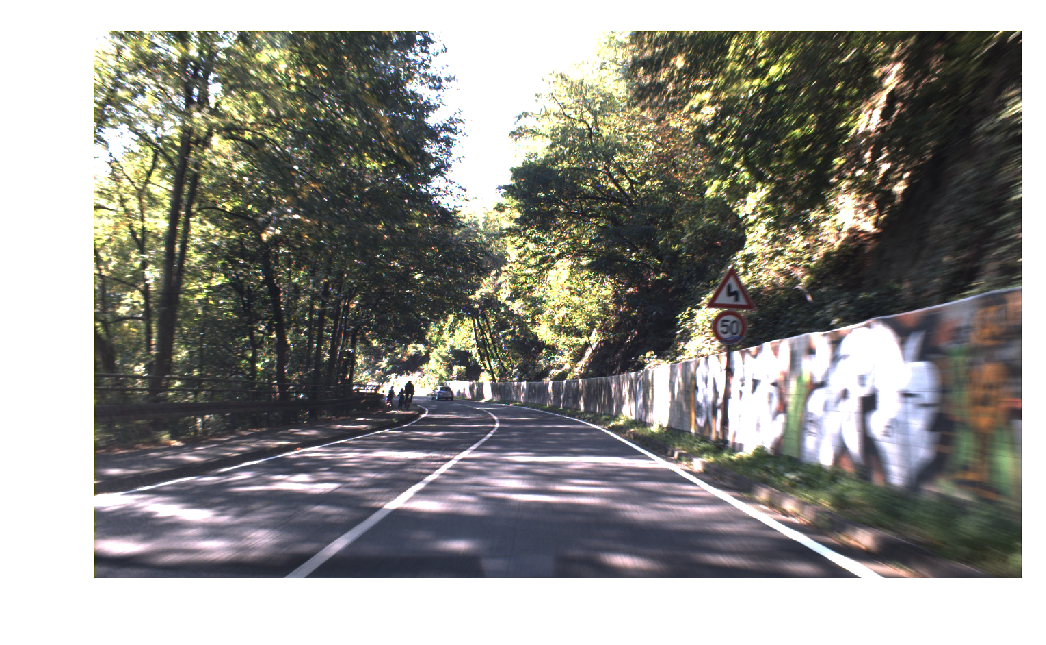

In [27]:
import matplotlib.pyplot as plt
% matplotlib inline

image_file, lC, tR, rC, bR, cat = annotation_parser("00004.ppm;906;407;955;459;2")
image_file = os.path.join("FullIJCNN2013", image_file)
img = cv2.imread(image_file, cv2.IMREAD_UNCHANGED)
img = img[:,:,::-1]

plt.figure(dpi=200)
plt.axis('off')
plt.imshow(img)
plt.show()

Now, I'll check that the annotations parser actually fetches the correct ROI (region of interest) 

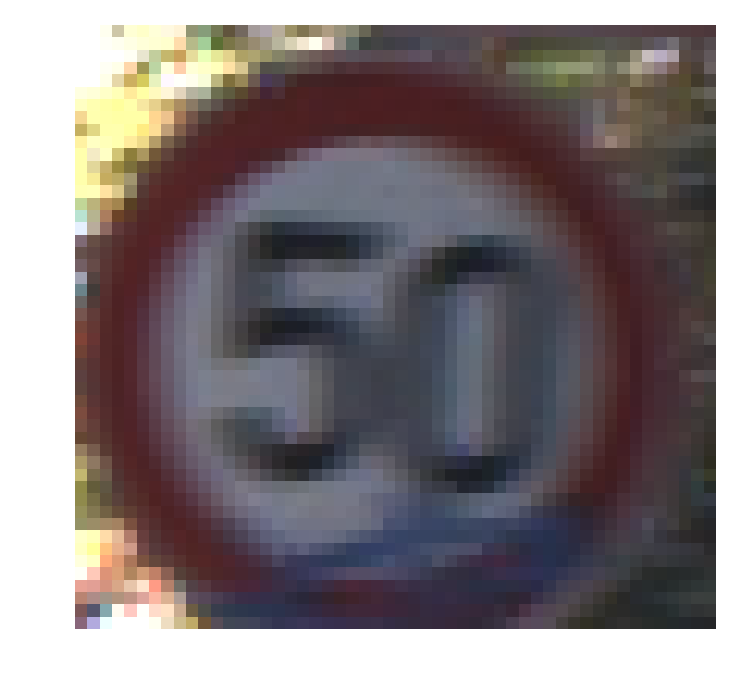

In [26]:
plt.figure(dpi=200)
plt.axis('off')
plt.imshow(img[tR:tR+(rC-lC),lC:lC+(bR-tR)])
plt.show()

## Helper functions to load the dataset

Now that i'm sure the function works properly, I'll proceed to define the following helper functions 

In [6]:
import os
import cv2
import imageio
import numpy as np
from sklearn.utils import shuffle


def get_annotated_ROI(annotation, path="FullIJCNN2013", as_gray=True, sep=";"):
    """
    get_annotated_ROI returns the ROI(an array) provided an annotation (string)
    
    Input
    -----
    - annotation(string): The annotation for a single image
    - path(string): Path containing the image files
    - as_gray(bool): If the image is loaded as RGB or Grayscale
    - sep(string): The separator for the annotations. (default ";")
    
    Returns
    -------
    - img(numpy.array): The ROI
    - category(int): The numerical category the image in the ROI belongs to
    """
    image_file, left_column, top_row, right_column, bottom_row, cat = annotation_parser(annotation, sep)
    image_file = os.path.join(path, image_file)
    img = imageio.imread(image_file, as_gray=as_gray)
    return img[top_row:top_row+(right_column-left_column),left_column:left_column+(bottom_row-top_row)].copy(), cat


def create_data_set_from_annotations(annotations_file, path="FullIJCNN2013", as_gray=True, target_shape = input_image_shape, sep=";"):
    """
    create_data_set_from_annotations Generates a shuffled dataset of ROIs (X) and their labels (y)
    provided an annotations_file corresponding to the german traffic sings dataset
    
    Input
    -----
    - annotation_file(string): The name of annotations file
    - path(string): Path containing the annotations file
    - as_gray(bool): If the image is loaded as RGB or Grayscale
    - target_shape(tuple): Tuple with the expected size of each of the output ROIs'
    - sep(string): The separator for the annotations. (default ";")
    
    Returns
    -------
    - X(numpy.array): Array of ROIs, one for each index
    - y(numpy.array): Array of labels corresponding to each of the ROIs on X
    """
    X = list()
    y = list()
    the_file = os.path.join(path, annotations_file)
    with open(the_file, "r") as annf:
        for line in annf:
            img, cat = get_annotated_ROI(line, path, as_gray, sep)
            img = cv2.resize(img, target_shape)
            img = img.flatten() # To get flat arrays of the image
            X.append(img) 
            y.append(cat)
            
    X, y = np.array(X), np.array(y)
    X, y = shuffle(X, y)
    return X, y


def split_data(Xo, yo, test_size=test_size):
    """
    split_data splits the data set X, y in two sets train_data, test_data and, train_labels, test_labels
    where the amount of elements of the second set correspond to the `test_size`
    percent of the amount of X, y
    
    Input
    -----
    - X(numpy.array): Array of features
    - y(numpy.array): Array of labels
    - test_size(float): Percentage of split(defalt 0.2)
    
    Returns
    -------
    - train_data(numpy.array) features to train
    - test_data(numpy.array) features to test
    - train_labels(numpy.array) labels of train_data
    - test_labels(numpy.array) labels of test_data
    
    """
    data_size = len(Xo)
    X, y = shuffle(Xo, yo)
    if (len(y) == data_size and test_size*data_size <= data_size) and (test_size <= 1.0):
        train_sz = int((1-test_size)*data_size)
        test_sz = int(test_size*data_size)
        
        train_data = np.zeros((train_sz,) + X.shape[1:])
        train_labels = np.zeros(train_sz)
        test_data = np.zeros((test_sz,) + X.shape[1:])
        test_labels = np.zeros(test_sz)
        
        for e in range(train_sz):
            index = np.random.randint(data_size)
            train_data[e] = X[index]
            train_labels[e] = y[index]
            
        for e in range(test_sz):
            index = np.random.randint(data_size)
            test_data[e] = X[index]
            test_labels[e] = y[index]
            
        return train_data, test_data, train_labels, test_labels
    else:
        print("Size miss_match")
        return Xo, yo, Xo, yo

## Loading the dataset

The dataset can be loaded in one single line, it consists of an array of features and one of labels,
where the features are images of 28x28(target_shape).


In [7]:
X, y = create_data_set_from_annotations("gt.txt")

Checking the shapes 

In [8]:
X.shape

(1213, 784)

In [9]:
y.shape

(1213,)

Now, visualize a random image (I know it says 28, but the helper functions perform shuffling of data, so each run of the notebook puts a random image at the 28th element of the features array X) 

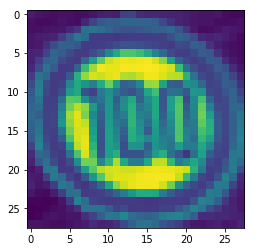

In [29]:
plt.imshow(np.resize(X[28], input_image_shape))
plt.show()

The dimensions of the features array are, 

In [11]:
X.ndim

2

In [12]:
X[0].shape

(784,)

# Training a LogisticRegression

Now, we import the `LogisticRegression` module from `sklearn.linear_model` package.
Also, we import an utility function `train_test_split` to perform the split of datasets into training and testing sets. I could use that function, but I've decided to go with my own dataset splitter `split_data` in order to be consistent across my different reports

In [13]:
from sklearn.linear_model import LogisticRegression
#from sklearn.model_selection import train_test_split

In [30]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=28)
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.20)

Now, checking the shapes of the output arrays, we get 

In [31]:
X_train.shape

(970, 784)

In [32]:
X_test.shape

(242, 784)

In [33]:
X_test.shape[0] + X_train.shape[0]

1212

# Actually training the model

Now, I'll make an instance of `LogisticRegression` with a regularization parameter of 0.01. I'll name it `clf`.

In [34]:
clf = LogisticRegression(C=0.01)

The training consist of feeding the instance with the training arrays

In [35]:
clf.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

I'll make a simple prediction on the test set, and will check with a simple graph that the prediction was good.
I need to define a dictionary with the equivalence of the category result and its meaning, just to see how good it performs.

The prediction is,

In [37]:
res = clf.predict(X_test)

And the dictionary is, 

In [45]:
cat_dict = {0 : " speed limit 20 (prohibitory)",
1 : " speed limit 30 (prohibitory)",
2 : " speed limit 50 (prohibitory)",
3 : " speed limit 60 (prohibitory)",
4 : " speed limit 70 (prohibitory)",
5 : " speed limit 80 (prohibitory)",
6 : " restriction ends 80 (other)",
7 : " speed limit 100 (prohibitory)",
8 : " speed limit 120 (prohibitory)",
9 : " no overtaking (prohibitory)",
10 : " no overtaking (trucks) (prohibitory)",
11 : " priority at next intersection (danger)",
12 : " priority road (other)",
13 : " give way (other)",
14 : " stop (other)",
15 : " no traffic both ways (prohibitory)",
16 : " no trucks (prohibitory)",
17 : " no entry (other)",
18 : " danger (danger)",
19 : " bend left (danger)",
20 : " bend right (danger)",
21 : " bend (danger)",
22 : " uneven road (danger)",
23 : " slippery road (danger)",
24 : " road narrows (danger)",
25 : " construction (danger)",
26 : " traffic signal (danger)",
27 : " pedestrian crossing (danger)",
28 : " school crossing (danger)",
29 : " cycles crossing (danger)",
30 : " snow (danger)",
31 : " animals (danger)",
32 : " restriction ends (other)",
33 : " go right (mandatory)",
34 : " go left (mandatory)",
35 : " go straight (mandatory)",
36 : " go right or straight (mandatory)",
37 : " go left or straight (mandatory)",
38 : " keep right (mandatory)",
39 : " keep left (mandatory)",
40 : " roundabout (mandatory)",
41 : " restriction ends (overtaking) (other)",
42 : " restriction ends (overtaking (trucks)) (other)"}

Now, checking for the first element of the predictions and test images,

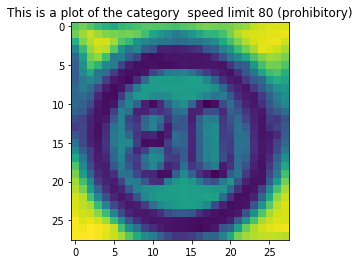

In [46]:
plt.imshow(X_test[0].reshape(28,28))
plt.title("This is a plot of the category {}".format(cat_dict[res[0]]))
plt.show()

# The score

The score of this classificator is,

In [40]:
clf.score(X_test, y_test)

0.8884297520661157